In [17]:
import pandas as pd
import os
import src.DevicePreprocessor
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import src.DPKMeans
import numpy as np
from sklearn.model_selection import train_test_split
import src.KMeans


In [18]:
"""Main function to execute the device usage analysis script."""
cwd = os.getcwd()
db_path = os.path.join(cwd, 'duckdb.db')    # Path to DuckDB database
pkl_path=os.path.join(cwd, 'src','software_data.pkl')
for file in os.listdir(os.path.join(cwd, 'private_data','raw')):
    if file!=".DS_Store":
        parquet_file = os.path.join(cwd, 'private_data', 'raw', file)
        output_parquet_path = os.path.join(cwd, 'private_data', 'out',file)
        analysis = src.DevicePreprocessor.DevicePreprocessor(db_path=db_path, parquet_file=parquet_file,pkl_path=pkl_path,output_parquet_path=output_parquet_path)
        analysis.preprocess()

In [19]:
k=3
data_list=[]
for file in os.listdir(os.path.join(cwd, 'private_data','out')):
    data_list.append(pd.DataFrame(pd.read_parquet(os.path.join(cwd, 'private_data','out',file))["l1_distance"]))
data = pd.concat(data_list, ignore_index=True)
scaler = MinMaxScaler(feature_range=(-10, 10))

# Fit and transform the data to normalize it between -1 and 1
data = scaler.fit_transform(data)
# Perform standard k-means



In [20]:


# Set seed for reproducibility

# Split data into train and test sets (80% train, 20% test)
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

# Initialize and fit KMeans on training data
kmeans = src.KMeans.KMeans(k)
train_clusters, train_centroids = kmeans.fit(train_data)

# Compute inertia (loss) for train and test sets
train_loss = kmeans.compute_inertia(train_data)/train_data.shape[0]
test_loss = kmeans.compute_inertia(test_data)/test_data.shape[0]



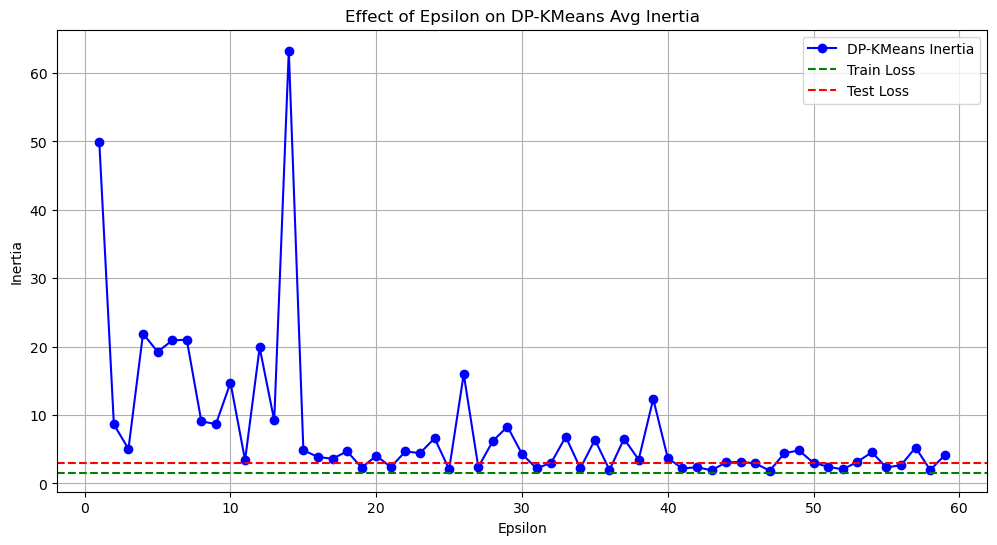

In [21]:

# Set random seed for reproducibility
np.random.seed(42)

# List of epsilon values to test
epsilons = [x for x in range(1, 60, 1)]
inertias = []

# Fit DPKMeans for different epsilon values and compute inertia
for eps in epsilons:
    dp_kmeans = src.DPKMeans.DPKMeans(k=3, eps=eps, iterations=10)
    dp_kmeans.fit(data)
    inertias.append(dp_kmeans.compute_inertia(data)/data.shape[0])

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(epsilons, inertias, marker='o', linestyle='-', color='b', label='DP-KMeans Inertia')
plt.axhline(y=train_loss, color='g', linestyle='--', label='Train Loss')
plt.axhline(y=test_loss, color='r', linestyle='--', label='Test Loss')

# Formatting the plot
plt.xlabel("Epsilon")
plt.ylabel("Inertia")
plt.title("Effect of Epsilon on DP-KMeans Avg Inertia")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()
